In [9]:
from segger.data.parquet.sample import STSampleParquet
from segger.training.segger_data_module import SeggerDataModule
from segger.training.train import LitSegger
from segger.models.segger_model import Segger
from segger.prediction.predict import load_model
from torch_geometric.nn import to_hetero
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
import numpy as np
from scipy.sparse import lil_matrix

xenium_data_dir = Path('data_xenium')
segger_data_dir = Path('data_segger')
# Base directory to store Pytorch Lightning models
models_dir = Path('models')


sample = STSampleParquet(
    base_dir=xenium_data_dir,
    n_workers=4,
    sample_type='xenium', # this could be 'xenium_v2' in case one uses the cell boundaries from the segmentation kit.
    #weights=gene_celltype_abundance_embedding, # uncomment if gene-celltype embeddings are available
)

In [11]:
# Initialize the Lightning data module
dm = SeggerDataModule(
    data_dir=segger_data_dir,
    batch_size=2,
    num_workers=2,
)

dm.setup()

# Get a sample batch from the data module
batch = dm.train[0]

In [12]:
def extract_attention_df(attention_weights, gene_names=None, edge_type='tx-tx'):
    """
    Extract attention weights into a structured dataset.
    
    Parameters
    ----------
    attention_df : list of tuples
        List of (edge_index, alpha) tuples for each layer
    gene_names : list, optional
        List of gene names corresponding to transcript indices

    Returns
    -------
    pd.DataFrame
        DataFrame containing transcript, gene, and attention weights for each layer and head
    """
    assert edge_type in ['tx-tx', 'tx-bd'], "Edge type must be 'tx-tx' or 'tx-bd'"
    
    # Create a list to store all the data
    data = []
    
    # Process each layer
    for layer_idx, (edge_index, alpha) in enumerate(attention_weights):
        if edge_type == 'tx-tx':
            alpha_tensor = alpha['tx']
            edge_index = edge_index['tx']
        elif edge_type == 'tx-bd':
            alpha_tensor = alpha['bd']
            edge_index = edge_index['bd']
        else:
            raise ValueError(f"Edge type must be 'tx-tx' or 'tx-bd', got {edge_type}")
        
        # Convert attention weights to numpy
        alpha_tensor = alpha_tensor.cpu().detach().numpy()
        # print(f"Alpha tensor shape: {alpha_tensor.shape}")
        edge_index = edge_index.cpu().detach().numpy()
        # print(f"Edge index shape: {edge_index.shape}")
        
        # Process each head
        for head_idx in range(alpha_tensor.shape[1]):
            # Get attention weights for this head
            head_weights = alpha_tensor[:, head_idx]
            # print(f"Head {head_idx + 1} shape: {head_weights.shape}")
            # print(f"Edge index shape: {edge_index.shape}")
            
            # Create entries for each edge
            for i, (src, dst) in enumerate(edge_index.T):
                entry = {
                    'source': int(src),
                    'target': int(dst),
                    'edge_type': edge_type,
                    'layer': layer_idx + 1,
                    'head': head_idx + 1,
                    'attention_weight': float(head_weights[i])
                }
                
                # Add gene names if available
                if gene_names is not None:
                    entry['source_gene'] = gene_names[src]
                    entry['target_gene'] = gene_names[dst]
                
                data.append(entry)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    return df

In [7]:
def visualize_attention_df(attention_df, layer_idx, head_idx, edge_type, gene_names=None):
    """
    Visualize attention weights of a data frame as a heatmap.
    
    Parameters
    ----------
    attention_df : torch.Tensor
        Attention weights of a data frame. Keys: 'source', 'target', 'edge_type', 'layer', 'head', 'attention_weight'.
    layer_idx : int
        Layer index.
    head_idx : int
        Head index.
    edge_type : str
        Edge type.
    gene_names : list
        a list of gene names ordered by the transcript indices.
        
    """
    # Get number of nodes
    num_nodes = len(attention_df['source'].unique())
    # Extract attention weights with given layer_idx and head_idx
    attention_df = attention_df[attention_df['layer'] == layer_idx + 1]
    attention_df = attention_df[attention_df['head'] == head_idx + 1]
    
    # Create adjacency matrix for visualization
    adj_matrix = np.zeros((num_nodes, num_nodes))
    
    # Fill adjacency matrix with attention weights
    for _, row in attention_df.iterrows():
        src = row['source']
        dst = row['target']
        adj_matrix[src, dst] = row['attention_weight']
    
    # Sort by genes if gene names are provided
    if gene_names is not None:
        # Sort nodes by gene names
        sorted_indices = sorted(attention_df['source'].unique(), key=lambda i: gene_names[i])
        # Reorder the adjacency matrix
        adj_matrix = adj_matrix[sorted_indices][:, sorted_indices]
        # Get sorted gene names for labels
        sorted_genes = [gene_names[i] for i in sorted_indices]
    else:
        sorted_genes = None
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(adj_matrix, cmap='viridis', annot=False, cbar=True)
    plt.title(f'Attention Weights - Layer {layer_idx + 1}, Head {head_idx + 1}, Edge Type: {edge_type}')
    plt.xlabel('Target Node (Transcript)')
    plt.ylabel('Source Node (Transcript)')
    
    # Add gene labels if available
    if sorted_genes is not None:
        # Add gene labels to the plot
        plt.xticks(np.arange(len(sorted_genes)) + 0.5, sorted_genes, rotation=90, ha='right')
        plt.yticks(np.arange(len(sorted_genes)) + 0.5, sorted_genes, rotation=0)
    
    plt.tight_layout()
    plt.savefig(Path('figures') / f'attention_layer_{layer_idx + 1}_head_{head_idx + 1}_{edge_type}.png')
    plt.close()

In [2]:
def summarize_attention_by_gene_df(attention_df, layer_idx, head_idx, edge_type, gene_to_idx, visualize=True):
    """
    Visualize attention weights of a data frame as a heatmap.
    
    Parameters
    ----------
    attention_df : pd.DataFrame
        Attention weights dataframe with columns: 'source', 'target', 'edge_type', 'layer', 'head', 'attention_weight', 'source_gene', 'target_gene'.
    layer_idx : int
        Layer index.
    head_idx : int
        Head index.
    edge_type : str
        Edge type.
    gene_to_idx : dict
        a dictionary of gene names to indices.
    """
    # Extract attention weights with given layer_idx and head_idx
    attention_df = attention_df[attention_df['layer'] == layer_idx + 1]
    attention_df = attention_df[attention_df['head'] == head_idx + 1]
    
    # Get unique genes by gene_to_idx
    num_genes = len(gene_to_idx)
    
    # Create adjacency matrix for visualization - use lil_matrix for efficient construction
    adj_matrix = lil_matrix((num_genes, num_genes), dtype=np.float32)
    count_matrix = lil_matrix((num_genes, num_genes), dtype=np.float32)
    
    # Fill adjacency matrix with attention weights
    for _, row in attention_df.iterrows():
        src_idx = gene_to_idx[row['source_gene']]
        dst_idx = gene_to_idx[row['target_gene']]
        adj_matrix[src_idx, dst_idx] += row['attention_weight']
        count_matrix[src_idx, dst_idx] += 1
    
    # Convert to CSR format for efficient computation
    adj_matrix = adj_matrix.tocsr()
    count_matrix = count_matrix.tocsr()
    
    if visualize:
        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(adj_matrix.toarray()/count_matrix.toarray(), cmap='viridis', annot=False, cbar=True)
        plt.title(f'Attention Weights - Layer {layer_idx + 1}, Head {head_idx + 1}, Edge Type: {edge_type}')
        plt.xlabel('Target Gene')
        plt.ylabel('Source Gene')
        
        # add gene labels
        # plt.xticks(np.arange(len(gene_to_idx)) + 0.5, sorted(gene_to_idx.keys()), rotation=90, ha='right')
        # plt.yticks(np.arange(len(gene_to_idx)) + 0.5, sorted(gene_to_idx.keys()), rotation=0)
        
        plt.tight_layout()
        plt.savefig(Path('figures') / f'attention_layer_{layer_idx + 1}_head_{head_idx + 1}_{edge_type}.png')
        plt.close()
    return adj_matrix, count_matrix

In [3]:
def compare_attention_patterns(attention_gene_matrix_dict, comparison_type='layers', layer_indices=None, head_indices=None, edge_type='tx-tx', top_k=20, gene_to_idx=None):
    """
    Create comparison plots between different attention layers or heads.
    
    Parameters
    ----------
    attention_gene_matrix_dict : dict
        Dictionary containing 'adj_matrix' and 'count_matrix'.
    comparison_type : str
        Type of comparison: 'layers' or 'heads'.
    layer_indices : list
        List of layer indices to compare. If None, uses all layers.
    head_indices : list
        List of head indices to compare. If None, uses all heads.
    edge_type : str
        Edge type to visualize.
    top_k : int
        Number of top attention pairs to visualize.
    gene_to_idx : dict
        Dictionary mapping gene names to indices.
    """
    # Create output directory
    figures_dir = Path('figures')
    figures_dir.mkdir(parents=True, exist_ok=True)
    
    layers = len(attention_gene_matrix_dict['adj_matrix'])
    heads = len(attention_gene_matrix_dict['adj_matrix'][0])
    
    # Set default indices if not provided
    if layer_indices is None:
        layer_indices = list(range(layers))
    if head_indices is None:
        head_indices = list(range(heads))
    
    # Get the reverse mapping: idx to gene
    if gene_to_idx:
        idx_to_gene = {idx: gene for gene, idx in gene_to_idx.items()}
    
    if comparison_type == 'layers':
        # Compare across layers for each head
        for head_idx in head_indices:
            # Create a figure for this head
            fig, axes = plt.subplots(1, len(layer_indices), figsize=(6*len(layer_indices), 5))
            if len(layer_indices) == 1:
                axes = [axes]  # Make it iterable
                
            # Get matrices for each layer with this head
            for i, layer_idx in enumerate(layer_indices):
                matrix = attention_gene_matrix_dict['adj_matrix'][layer_idx][head_idx].toarray()
                
                # Plot heatmap
                im = sns.heatmap(matrix, cmap='viridis', ax=axes[i], cbar=(i == len(layer_indices)-1))
                axes[i].set_title(f'Layer {layer_idx+1}, Head {head_idx+1}')
                axes[i].set_xlabel('Target Gene')
                axes[i].set_ylabel('Source Gene')
            
            plt.tight_layout()
            plt.savefig(figures_dir / f'layer_comparison_head_{head_idx+1}_{edge_type}.png')
            plt.close()
            
            # Create a plot showing top attention pairs across layers
            plt.figure(figsize=(12, 8))
            
            # Collect top gene pairs from each layer
            all_pairs = []
            for layer_idx in layer_indices:
                matrix = attention_gene_matrix_dict['adj_matrix'][layer_idx][head_idx].toarray()
                # Flatten and find top_k indices
                flat_indices = np.argsort(matrix.flatten())[-top_k:]
                # Convert flat indices to 2D indices
                for flat_idx in flat_indices:
                    src_idx = flat_idx // matrix.shape[1]
                    dst_idx = flat_idx % matrix.shape[1]
                    if gene_to_idx:
                        pair_name = f"{idx_to_gene[src_idx]}->{idx_to_gene[dst_idx]}"
                    else:
                        pair_name = f"Gene {src_idx}->Gene {dst_idx}"
                    all_pairs.append((pair_name, layer_idx, matrix[src_idx, dst_idx]))
            
            # Create DataFrame for easy plotting
            df = pd.DataFrame(all_pairs, columns=['Gene Pair', 'Layer', 'Attention Weight'])
            # Sort by attention weight for better visualization
            df = df.sort_values('Attention Weight', ascending=False).head(top_k)
            
            # Plot as grouped bar chart
            sns.barplot(data=df, x='Gene Pair', y='Attention Weight', hue='Layer', palette='viridis')
            plt.title(f'Top {top_k} Attention Weights Across Layers (Head {head_idx+1})')
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.savefig(figures_dir / f'top_attention_across_layers_head_{head_idx+1}_{edge_type}.png')
            plt.close()
            
    elif comparison_type == 'heads':
        # Compare across heads for each layer
        for layer_idx in layer_indices:
            # Create a figure for this layer
            fig, axes = plt.subplots(1, len(head_indices), figsize=(6*len(head_indices), 5))
            if len(head_indices) == 1:
                axes = [axes]  # Make it iterable
                
            # Get matrices for each head with this layer
            for i, head_idx in enumerate(head_indices):
                matrix = attention_gene_matrix_dict['adj_matrix'][layer_idx][head_idx].toarray()
                
                # Plot heatmap
                im = sns.heatmap(matrix, cmap='viridis', ax=axes[i], cbar=(i == len(head_indices)-1))
                axes[i].set_title(f'Layer {layer_idx+1}, Head {head_idx+1}')
                axes[i].set_xlabel('Target Gene')
                axes[i].set_ylabel('Source Gene')
            
            plt.tight_layout()
            plt.savefig(figures_dir / f'head_comparison_layer_{layer_idx+1}_{edge_type}.png')
            plt.close()
            
            # Create a plot showing top attention pairs across heads
            plt.figure(figsize=(12, 8))
            
            # Collect top gene pairs from each head
            all_pairs = []
            for head_idx in head_indices:
                matrix = attention_gene_matrix_dict['adj_matrix'][layer_idx][head_idx].toarray()
                # Flatten and find top_k indices
                flat_indices = np.argsort(matrix.flatten())[-top_k:]
                # Convert flat indices to 2D indices
                for flat_idx in flat_indices:
                    src_idx = flat_idx // matrix.shape[1]
                    dst_idx = flat_idx % matrix.shape[1]
                    if gene_to_idx:
                        pair_name = f"{idx_to_gene[src_idx]}->{idx_to_gene[dst_idx]}"
                    else:
                        pair_name = f"Gene {src_idx}->Gene {dst_idx}"
                    all_pairs.append((pair_name, head_idx, matrix[src_idx, dst_idx]))
            
            # Create DataFrame for easy plotting
            df = pd.DataFrame(all_pairs, columns=['Gene Pair', 'Head', 'Attention Weight'])
            # Sort by attention weight for better visualization
            df = df.sort_values('Attention Weight', ascending=False).head(top_k)
            
            # Plot as grouped bar chart
            sns.barplot(data=df, x='Gene Pair', y='Attention Weight', hue='Head', palette='viridis')
            plt.title(f'Top {top_k} Attention Weights Across Heads (Layer {layer_idx+1})')
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.savefig(figures_dir / f'top_attention_across_heads_layer_{layer_idx+1}_{edge_type}.png')
            plt.close()
    else:
        raise ValueError(f"Invalid comparison type: {comparison_type}. Must be 'layers' or 'heads'.")

In [13]:
def visualize_attention_difference(attention_df, edge_type, compare_type='layers', layer_indices=None, head_indices=None, gene_names=None):
    """
    Visualize differences in attention weights across layers or heads at transcript level.
    
    Parameters
    ----------
    attention_df : pd.DataFrame
        Attention weights dataframe with columns: 'source', 'target', 'edge_type', 'layer', 'head', 'attention_weight'.
    edge_type : str
        Edge type to filter by (e.g., 'tx-tx', 'tx-bd').
    compare_type : str
        Type of comparison: 'layers' or 'heads'.
    layer_indices : list
        List of layer indices to compare. If None, uses all available layers.
    head_indices : list
        List of head indices to compare. If None, uses all available heads.
    gene_names : list
        List of gene names ordered by the transcript indices.
    """
    # Filter by edge_type
    filtered_df = attention_df[attention_df['edge_type'] == edge_type]
    
    # Get all available layers and heads if not specified
    if layer_indices is None:
        layer_indices = sorted(filtered_df['layer'].unique())
    if head_indices is None:
        head_indices = sorted(filtered_df['head'].unique())
    
    # Create figures directory if it doesn't exist
    figures_dir = Path('figures')
    if not figures_dir.exists():
        figures_dir.mkdir(parents=True, exist_ok=True)
    
    if compare_type == 'layers':
        # Compare differences between layers for each head
        for head_idx in head_indices:
            head_df = filtered_df[filtered_df['head'] == head_idx]
            
            # Skip if no data for this head
            if head_df.empty:
                print(f"No data found for head {head_idx}")
                continue
                
            # We need at least 2 layers to compare
            if len(layer_indices) < 2:
                print(f"Need at least 2 layers to compare for head {head_idx}")
                continue
            
            # Get number of nodes
            num_nodes = len(head_df['source'].unique())
            if num_nodes == 0:
                print(f"No nodes found for head {head_idx}")
                continue
            
            # For each pair of layers, compute difference
            for i in range(len(layer_indices) - 1):
                for j in range(i + 1, len(layer_indices)):
                    layer1 = layer_indices[i]
                    layer2 = layer_indices[j]
                    
                    # Create adjacency matrices for both layers with lil_matrix
                    adj_matrix1 = np.zeros((num_nodes, num_nodes), dtype=np.float32)
                    adj_matrix2 = np.zeros((num_nodes, num_nodes), dtype=np.float32)
                    
                    # Fill adjacency matrices
                    layer1_df = head_df[head_df['layer'] == layer1]
                    layer2_df = head_df[head_df['layer'] == layer2]
                    
                    # Skip if either layer has no data
                    if layer1_df.empty or layer2_df.empty:
                        print(f"No data found for layer {layer1} or {layer2} in head {head_idx}")
                        continue
                    
                    for _, row in layer1_df.iterrows():
                        src = row['source']
                        dst = row['target']
                        adj_matrix1[src, dst] = row['attention_weight']
                    
                    for _, row in layer2_df.iterrows():
                        src = row['source']
                        dst = row['target']
                        adj_matrix2[src, dst] = row['attention_weight']
                    
                    
                    # Compute difference
                    diff_matrix = adj_matrix2 - adj_matrix1
                    
                    # Sort by genes if gene names are provided
                    if gene_names is not None:
                        # Get valid source indices that are present in the data
                        valid_indices = sorted(list(set(head_df['source'].unique()) & set(range(len(gene_names)))))
                        
                        if not valid_indices:
                            print(f"No valid gene indices found for head {head_idx}")
                            continue
                            
                        # Sort indices by gene names
                        sorted_indices = sorted(valid_indices, key=lambda i: gene_names[i])
                        
                        # Reorder the difference matrix if there are valid indices
                        if len(sorted_indices) > 0:
                            diff_matrix = diff_matrix[sorted_indices][:, sorted_indices]
                            sorted_genes = [gene_names[i] for i in sorted_indices]
                        else:
                            sorted_genes = None
                    else:
                        sorted_genes = None
                    
                    # Plot heatmap of differences
                    plt.figure(figsize=(12, 10))
                    
                    # Use diverging colormap for difference visualization
                    vmax = max(abs(np.min(diff_matrix)), abs(np.max(diff_matrix)))
                    if vmax == 0:
                        vmax = 1  # Avoid division by zero
                        
                    sns.heatmap(diff_matrix, cmap='coolwarm', annot=False, cbar=True, vmin=-vmax, vmax=vmax)
                    plt.title(f'Attention Weight Difference - Layer {layer2} vs Layer {layer1}, Head {head_idx}, Edge Type: {edge_type}')
                    plt.xlabel('Target Node (Transcript)')
                    plt.ylabel('Source Node (Transcript)')
                    
                    # Add gene labels if available (optional)
                    # if sorted_genes is not None:
                    #     plt.xticks(np.arange(len(sorted_genes)) + 0.5, sorted_genes, rotation=90, ha='right')
                    #     plt.yticks(np.arange(len(sorted_genes)) + 0.5, sorted_genes, rotation=0)
                    
                    plt.tight_layout()
                    plt.savefig(figures_dir / f'attention_diff_layer{layer2}vs{layer1}_head{head_idx}_{edge_type}.png')
                    plt.close()
    
    elif compare_type == 'heads':
        # Compare differences between heads for each layer
        for layer_idx in layer_indices:
            layer_df = filtered_df[filtered_df['layer'] == layer_idx]
            
            # Skip if no data for this layer
            if layer_df.empty:
                print(f"No data found for layer {layer_idx}")
                continue
                
            # We need at least 2 heads to compare
            if len(head_indices) < 2:
                print(f"Need at least 2 heads to compare for layer {layer_idx}")
                continue
            
            # Get number of nodes
            num_nodes = len(layer_df['source'].unique())
            if num_nodes == 0:
                print(f"No nodes found for layer {layer_idx}")
                continue
            
            # For each pair of heads, compute difference
            for i in range(len(head_indices) - 1):
                for j in range(i + 1, len(head_indices)):
                    head1 = head_indices[i]
                    head2 = head_indices[j]
                    
                    # Create adjacency matrices for both heads
                    adj_matrix1 = np.zeros((num_nodes, num_nodes), dtype=np.float32)
                    adj_matrix2 = np.zeros((num_nodes, num_nodes), dtype=np.float32)
                    
                    # Fill adjacency matrices
                    head1_df = layer_df[layer_df['head'] == head1]
                    head2_df = layer_df[layer_df['head'] == head2]
                    
                    # Skip if either head has no data
                    if head1_df.empty or head2_df.empty:
                        print(f"No data found for head {head1} or {head2} in layer {layer_idx}")
                        continue
                    
                    for _, row in head1_df.iterrows():
                        src = row['source']
                        dst = row['target']
                        adj_matrix1[src, dst] = row['attention_weight']
                    
                    for _, row in head2_df.iterrows():
                        src = row['source']
                        dst = row['target']
                        adj_matrix2[src, dst] = row['attention_weight']
                    
                    
                    # Compute difference
                    diff_matrix = adj_matrix2 - adj_matrix1
                    
                    # Sort by genes if gene names are provided
                    if gene_names is not None:
                        # Get valid source indices that are present in the data
                        valid_indices = sorted(list(set(layer_df['source'].unique()) & set(range(len(gene_names)))))
                        
                        if not valid_indices:
                            print(f"No valid gene indices found for layer {layer_idx}")
                            continue
                            
                        # Sort indices by gene names
                        sorted_indices = sorted(valid_indices, key=lambda i: gene_names[i])
                        
                        # Reorder the difference matrix if there are valid indices
                        if len(sorted_indices) > 0:
                            diff_matrix = diff_matrix[sorted_indices][:, sorted_indices]
                            sorted_genes = [gene_names[i] for i in sorted_indices]
                        else:
                            sorted_genes = None
                    else:
                        sorted_genes = None
                    
                    # Plot heatmap of differences
                    plt.figure(figsize=(12, 10))
                    
                    # Use diverging colormap for difference visualization
                    vmax = max(abs(np.min(diff_matrix)), abs(np.max(diff_matrix)))
                    if vmax == 0:
                        vmax = 1  # Avoid division by zero
                        
                    sns.heatmap(diff_matrix, cmap='coolwarm', annot=False, cbar=True, vmin=-vmax, vmax=vmax)
                    plt.title(f'Attention Weight Difference - Head {head2} vs Head {head1}, Layer {layer_idx}, Edge Type: {edge_type}')
                    plt.xlabel('Target Node (Transcript)')
                    plt.ylabel('Source Node (Transcript)')
                    
                    # Add gene labels if available (optional)
                    # if sorted_genes is not None:
                    #     plt.xticks(np.arange(len(sorted_genes)) + 0.5, sorted_genes, rotation=90, ha='right')
                    #     plt.yticks(np.arange(len(sorted_genes)) + 0.5, sorted_genes, rotation=0)
                    
                    plt.tight_layout()
                    plt.savefig(figures_dir / f'attention_diff_head{head2}vs{head1}_layer{layer_idx}_{edge_type}.png')
                    plt.close()
    
    else:
        raise ValueError(f"Invalid comparison type: {compare_type}. Must be 'layers' or 'heads'.")

In [14]:
# Paths to data and models
model_version = 1
model_path = Path('models') / "lightning_logs" / f"version_{model_version}"
ls = load_model(model_path / "checkpoints")

ls.eval()

# load transcripts
transcripts = pd.read_parquet(Path('data_xenium') / 'transcripts.parquet')

# Move batch to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ls = ls.to(device)

# Initialize the Lightning data module
dm = SeggerDataModule(
    data_dir=Path('data_segger'),
    batch_size=2,
    num_workers=2,
)

dm.setup()

# Get a sample batch from the data module
batch = dm.train[0].to(device)

# Get gene names from the batch data and transcripts
# Convert tensor IDs to numpy array and then to list for indexing
transcript_ids = batch['tx'].id.cpu().numpy()
# Create a mapping from transcript ID to gene name
id_to_gene = dict(zip(transcripts['transcript_id'], transcripts['feature_name']))
# Get gene names in the same order as the batch
gene_names = [id_to_gene[id] for id in transcript_ids]

# Run forward pass to get attention weights
with torch.no_grad():
    # Access the heterogeneous model
    hetero_model = ls.model
    # Get node features and edge indices
    x_dict = batch.x_dict
    edge_index_dict = batch.edge_index_dict
    
    # Run forward pass through the model
    _, attention_weights = hetero_model(x_dict, edge_index_dict)


/Users/finleyyu/anaconda3/envs/segger/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/Users/finleyyu/anaconda3/envs/segger/lib/python3.11/site-packages/segger/data/parquet/pyg_dataset.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlist

: 

In [ ]:
edge_type = "tx-tx"

# Extract attention weights into a structured dataset
attention_df = extract_attention_df(attention_weights, gene_names)

# Visualize transcript-level attention differences
print("Visualizing transcript-level attention differences...")
# Extract attention weights into a structured dataset for the whole batch
attention_df = extract_attention_df(attention_weights, gene_names)

# Set layer and head indices for the comparison
layer_indices = [1, 2]  # Assuming 1-indexed layers in the dataframe
head_indices = [1, 2]   # Assuming 1-indexed heads in the dataframe

# Visualize differences between layers for each head
visualize_attention_difference(
    attention_df=attention_df,
    edge_type=edge_type,
    compare_type='layers',
    layer_indices=layer_indices,
    head_indices=head_indices,
    gene_names=gene_names
)

# Visualize differences between heads for each layer
visualize_attention_difference(
    attention_df=attention_df,
    edge_type=edge_type,
    compare_type='heads',
    layer_indices=layer_indices,
    head_indices=head_indices,
    gene_names=gene_names
)
# # Save the attention weights dataset
# output_path = Path(f'figures/attention_weights_{edge_type}.csv')
# attention_df.to_csv(output_path, index=False)
# print(f"Saved attention weights dataset to {output_path}")

Visualizing transcript-level attention differences...


In [12]:
def sum_attention_by_gene(attention_df, layer_idx=None, head_idx=None):
    """
    Create a new dataframe with the attention weights and number of edges from one gene to another gene.
    
    Parameters
    ----------
    attention_df : pd.DataFrame
        The attention weights dataframe.
    layer_idx : int, optional
        Specific layer index to filter by. If None, includes all layers.
    head_idx : int, optional
        Specific head index to filter by. If None, includes all heads.
        
    Returns
    -------
    pd.DataFrame
        A dataframe with the attention weights and number of edges from one gene to another gene.
    
    """
    # Filter by edge type
    attention_df = attention_df[attention_df['edge_type'] == 'tx-tx']
    
    # Filter by layer and head if specified
    if layer_idx is not None:
        attention_df = attention_df[attention_df['layer'] == layer_idx + 1]  # +1 because layer indices are 1-based in the dataframe
    if head_idx is not None:
        attention_df = attention_df[attention_df['head'] == head_idx + 1]  # +1 because head indices are 1-based in the dataframe
    
    # Select relevant columns and group by genes
    attention_df = attention_df[['source_gene', 'target_gene', 'attention_weight']]
    attention_df = attention_df.groupby(['source_gene', 'target_gene']).agg({'attention_weight': 'sum'}).reset_index()
    
    # Add a column for the number of edges
    attention_df['num_edges'] = attention_df.groupby('source_gene')['target_gene'].transform('count')
    
    return attention_df

In [23]:
attention_gene_df = sum_attention_by_gene(attention_df, layer_idx=0, head_idx=0)
attention_gene_df.head(10)

,source_gene,target_gene,attention_weight,num_edges
0,ABCC11,ABCC11,0.182055,3
1,ABCC11,AIF1,0.087264,3
2,ABCC11,EIF4A1,0.346123,3
3,ACE2,ACE2,0.000129,3
4,ACE2,EDN1,0.000165,3
5,ACE2,LAPTM5,0.000137,3
6,ACKR1,ACKR1,0.202666,3
7,ACKR1,HSP90B1,0.201552,3
8,ACKR1,PPA1,0.580612,3
9,ACTA2,ACTA2,12.924442,54


In [33]:
# create a matrix of gene attention weights
num_genes = len(transcripts['feature_name'].unique()) # 538
adj_gene_matrix = np.zeros((num_genes, num_genes))
count_gene_matrix = np.zeros((num_genes, num_genes))
# construct the gene to index mapping
gene_to_idx = {gene: idx for idx, gene in enumerate(transcripts['feature_name'].unique())}

In [ ]:
def summarize_attention_by_gene_df(attention_df, layer_idx, head_idx, edge_type, gene_to_idx, visualize=True):
    """
    Visualize attention weights of a data frame as a heatmap.
    
    Parameters
    ----------
    attention_df : pd.DataFrame
        Attention weights dataframe with columns: 'source', 'target', 'edge_type', 'layer', 'head', 'attention_weight', 'source_gene', 'target_gene'.
    layer_idx : int
        Layer index.
    head_idx : int
        Head index.
    edge_type : str
        Edge type.
    gene_to_idx : dict
        a dictionary of gene names to indices.
    """
    # Extract attention weights with given layer_idx and head_idx
    attention_df = attention_df[attention_df['layer'] == layer_idx + 1]
    attention_df = attention_df[attention_df['head'] == head_idx + 1]
    
    # Get unique genes by gene_to_idx
    num_genes = len(gene_to_idx)
    
    # Create adjacency matrix for visualization
    adj_matrix = np.zeros((num_genes, num_genes))
    # create a count matrix for visualization
    count_matrix = np.zeros((num_genes, num_genes))
    
    # Fill adjacency matrix with attention weights
    for _, row in attention_df.iterrows():
        src_gene = row['source_gene']
        dst_gene = row['target_gene']
        src_idx = gene_to_idx[src_gene]
        dst_idx = gene_to_idx[dst_gene]
        adj_matrix[src_idx, dst_idx] += row['attention_weight']
        count_matrix[src_idx, dst_idx] += 1
    
    if visualize:
        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(adj_matrix/count_matrix, cmap='viridis', annot=False, cbar=True)
        plt.title(f'Attention Weights - Layer {layer_idx + 1}, Head {head_idx + 1}, Edge Type: {edge_type}')
        plt.xlabel('Target Gene')
        plt.ylabel('Source Gene')
        
        # add gene labels
        # plt.xticks(np.arange(len(gene_to_idx)) + 0.5, sorted(gene_to_idx.keys()), rotation=90, ha='right')
        # plt.yticks(np.arange(len(gene_to_idx)) + 0.5, sorted(gene_to_idx.keys()), rotation=0)
        
        plt.tight_layout()
        plt.savefig(Path('figures') / f'attention_layer_{layer_idx + 1}_head_{head_idx + 1}_{edge_type}.png')
        plt.close()
    return adj_matrix, count_matrix


# visualize the attention weights
adj_matrix, count_matrix = summarize_attention_by_gene_df(attention_df, layer_idx=0, head_idx=0, edge_type='tx-tx', gene_to_idx=gene_to_idx)

/var/folders/6r/d03g4jld7610g31_m390nfwc0000gn/T/ipykernel_67222/1248123277.py:42: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(adj_matrix/count_matrix, cmap='viridis', annot=False, cbar=True)


(array([[100.11452112,   0.52261245,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.97267691,  65.65473216,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.29936937, ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]),
 array([[426.,   2.,   0., ...,   0.,   0.,   0.],
        [  6., 243.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   2., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]))

In [45]:
# create a matrix of gene attention weights
num_genes = len(transcripts['feature_name'].unique()) # 538
# construct the gene to index mapping
gene_to_idx = {gene: idx for idx, gene in enumerate(transcripts['feature_name'].unique())}
# Create a mapping from transcript ID to gene name
id_to_gene = dict(zip(transcripts['transcript_id'], transcripts['feature_name']))

attention_gene_matrix_dict = {"layer_idx": [], "head_idx": [], "adj_matrix": [], "count_matrix": []}

layers = 2
heads = 2

attention_gene_matrix_dict = {
    "adj_matrix": [[np.zeros((num_genes, num_genes)) for _ in range(heads)] for _ in range(layers)],
    "count_matrix": [[np.zeros((num_genes, num_genes)) for _ in range(heads)] for _ in range(layers)]
}

# travel through each batch and add up the adj_matrix and count_matrix
for batch in dm.train[0:1]:
    with torch.no_grad():
        # Get node features and edge indices
        x_dict = batch.x_dict
        edge_index_dict = batch.edge_index_dict
        
        # Run forward pass through the model
        _, attention_weights = hetero_model(x_dict, edge_index_dict)
        
        # Get gene names from the batch data and transcripts
        # Convert tensor IDs to numpy array and then to list for indexing
        transcript_ids = batch['tx'].id.cpu().numpy()
        
        # Get gene names in the same order as the batch
        gene_names = [id_to_gene[id] for id in transcript_ids]
        
        # Extract attention weights into a structured dataset
        attention_df = extract_attention_df(attention_weights, gene_names)
        
        for layer_idx in range(layers):
            for head_idx in range(heads):
                adj_matrix, count_matrix = summarize_attention_by_gene_df(attention_df, layer_idx=layer_idx, head_idx=head_idx, edge_type='tx-tx', gene_to_idx=gene_to_idx, visualize=False)
                # update the attention_gene_matrix_dict
                attention_gene_matrix_dict["adj_matrix"][layer_idx][head_idx] += adj_matrix
                attention_gene_matrix_dict["count_matrix"][layer_idx][head_idx] += count_matrix
        
# compute the average attention weights
for layer_idx in range(layers):
    for head_idx in range(heads):
        attention_gene_matrix_dict["adj_matrix"][layer_idx][head_idx] /= (attention_gene_matrix_dict["count_matrix"][layer_idx][head_idx] + 1e-10)
        
        # visualize the attention weights
        plt.figure(figsize=(10, 8))
        sns.heatmap(attention_gene_matrix_dict["adj_matrix"][layer_idx][head_idx], cmap='viridis', annot=False, cbar=True)
        plt.title(f'Attention Weights - Layer {layer_idx + 1}, Head {head_idx + 1}, Edge Type: {edge_type}')
        
        plt.xlabel('Target Gene')
        plt.ylabel('Source Gene')
        
        # add gene labels
        plt.xticks(np.arange(len(gene_to_idx)) + 0.5, sorted(gene_to_idx.keys()), rotation=90, ha='right')
        plt.yticks(np.arange(len(gene_to_idx)) + 0.5, sorted(gene_to_idx.keys()), rotation=0)
        
        plt.tight_layout()
        plt.savefig(Path('figures') / f'attention_layer_{layer_idx + 1}_head_{head_idx + 1}_{edge_type}.png')
        plt.close()


/Users/finleyyu/anaconda3/envs/segger/lib/python3.11/site-packages/segger/data/parquet/pyg_dataset.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(fil

In [44]:
attention_gene_matrix_dict["adj_matrix"]


[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [ ]:
# Plot heatmap
for layer_idx in range(layers):
    for head_idx in range(heads):
        plt.figure(figsize=(10, 8))
        sns.heatmap(attention_gene_matrix_dict[(layer_idx, head_idx)], cmap='viridis', annot=False, cbar=True)
        plt.title(f'Attention Weights - Layer {layer_idx + 1}, Head {head_idx + 1}, Edge Type: {edge_type}')
        plt.xlabel('Target Gene')
        plt.ylabel('Source Gene')
        
        # add gene labels
        # plt.xticks(np.arange(len(gene_to_idx)) + 0.5, sorted(gene_to_idx.keys()), rotation=90, ha='right')
        # plt.yticks(np.arange(len(gene_to_idx)) + 0.5, sorted(gene_to_idx.keys()), rotation=0)
        
        plt.tight_layout()
        plt.savefig(Path('figures') / f'attention_layer_{layer_idx + 1}_head_{head_idx + 1}_{edge_type}.png')
        plt.close()

/var/folders/6r/d03g4jld7610g31_m390nfwc0000gn/T/ipykernel_67222/640619731.py:3: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(adj_gene_matrix/count_gene_matrix, cmap='viridis', annot=False, cbar=True)


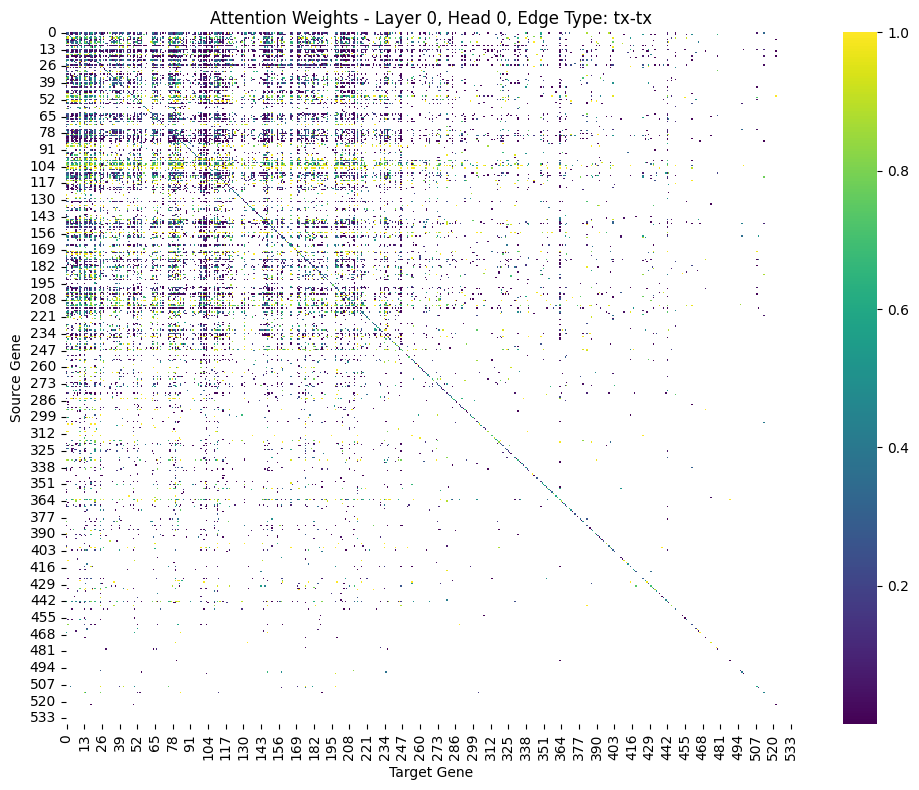